# Perlmutter99 Data Analysis

## Introduction

In their paper entitled "Measurements of Omega and Lambda from high-redshift supernovae", S. Perlmutter et al used data from the Supernova Cosmology Project to calculate the matter density of the universe, Omega_matter. The data gives the luminosity (m) for different amounts of redshift (z), and m is a function of Omat, among other parameters. The value they calculated was approximately 0.28(+/-)1. This project uses the data from their paper to calculate Omega_matter using Markov Chain Monte Carlo (MCMC) methods.

MCMC methods are used to take samples of a probability distribution. In this project the probabilty distribution is the log-likelihood in the foreground-background model, where the foreground and background distributions are given by gaussians. The MCMC sampler takes in initial parameters and alters them, travelling though the space of possible parameters and accepting or rejecting parameters based on the log-likelihood.

This project uses both the Gibbs sampler and the EMCEE sampler, which are predicted to yeild results that are similar to eachother as a check of both methods.

## The Code

### Setting up the function to fit

The following is code written by Dr. Dustin Lang. It creates the function that is being fitted. Comments by Dr. Lang are in italics.

In [1]:
#using Pkg
# This is a numerical integration package that we use for cosmology distances
#Pkg.add("QuadGK")

In [2]:
# For Flat Lambda CDM, the distances should be computable using a "special" function
# hyp2f1 which is in scipy but I couldn't find in Julia other than in the "Nemo" package,
# but I couldn't get that working, so below I'm just using the integral version.
# Pkg.add("Nemo")

In [3]:
using QuadGK
#using Nemo
using Plots
using Statistics

*This is a cheap function to read in the data table.*

In [4]:
function read_data()
    open("p99-data.txt", "r") do io
        line = readline(io)
        # drop "#"
        if line[1] == '#'
            line = line[2:end]
        end
        words = split(line)
        # println(words)
        ncols = length(words)
        lines = readlines(io)
        nlines = length(lines)
        #println("Read ", nlines, " lines")
        names = []
        redshift = zeros(nlines)
        m_b_eff = zeros(nlines)
        sigma_m_b_eff = zeros(nlines)
        for i in 1:nlines
            #println("Line: ", lines[i])
            # HACK --- I'm hard-coding which columns contain which data
            words = split(lines[i])
            push!(names, words[1])
            redshift[i] = parse(Float64, words[2])
            m_b_eff[i] = parse(Float64, words[9])
            sigma_m_b_eff[i] = parse(Float64, words[10])
        end
        return names, redshift, m_b_eff, sigma_m_b_eff
    end
end;

Read and plot the data:

In [5]:
(name, z, m, merr) = read_data();

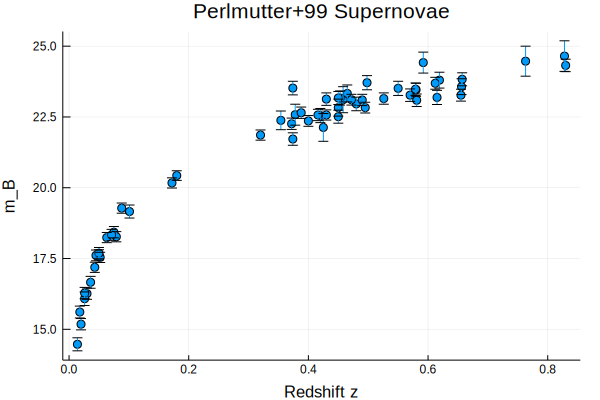

In [6]:
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")

*Distance functions for a Flat Lambda CDM cosmology model.*

In [7]:
# These functions are taken from astropy.cosmology, specialized for
# the FlatLambdaCDM model.
#

# A minimal Flat Lambda CDM model
mutable struct LCDM
    Om0::Float64
    Ode0::Float64
    hubble_distance::Float64
end
function luminosity_distance(cosmology, z)
    return (1. + z) * comoving_transverse_distance(cosmology, z)
end
function comoving_transverse_distance(cosmology, z)
    return comoving_transverse_distance_z1z2(cosmology, 0., z)
end
function comoving_transverse_distance_z1z2(cosmology, z1, z2)
    # HERE we're assuming Ok0=0
    # (Omega curvature; the effective curvature density/critical density at z=0)
    return comoving_distance_z1z2(cosmology, z1, z2)
end

function comoving_distance_z1z2(cosmology, z1, z2)
    #hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    integral_comoving_distance_z1z2(cosmology, z1, z2)
end

function integral_comoving_distance_z1z2(cosmology, z1, z2)
    function flcdm_inv_efunc_norel(z)
        Om0 = cosmology.Om0
        Ode0 = cosmology.Ode0
        return ((1. + z)^3 * Om0 + Ode0) ^ -0.5
    end
    # HERE we turn off relativistic species (Tcmb=0)
    (integral,error) = quadgk(flcdm_inv_efunc_norel, z1, z2)
    return cosmology.hubble_distance * integral
end

function hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    # def _hypergeometric_comoving_distance_z1z2(self, z1, z2):
    s = ((1 - cosmology.Om0) / cosmology.Om0) ^ (1. / 3)
    # Use np.sqrt here to handle negative s (Om0>1).
    prefactor = cosmology.hubble_distance / sqrt(s * cosmology.Om0)
    return prefactor * (T_hypergeometric(s / (1 + z1)) -
                        T_hypergeometric(s / (1 + z2)))
end
function T_hypergeometric(x)
    #from scipy.special import hyp2f1
    return 2 * sqrt(x) * Nemo.hyp2f1(1. / 6, 1. / 2, 7. / 6, -x^3)
end;

In [8]:
# Perlmutter+ define D_L = H_0 d_L; you could drop the factor of hubble_distance
# from luminosity_distance here if you wanted.  It will all just get folded into the
# M_B offset.
function distance_modulus(universe, z)
    5. * log10.(luminosity_distance(universe, z) / 10.)
end;

### Calculate the log-likelihood function and rewrite in a more accessible form

The log-likelihood is calculated using a foreground-background model, where the foreground distribution is a gaussian centered at the predicted value of m with variance given by the error in m (merr), the background distribution is a gaussain centered at Y with standard deviation V. This code is altered from the class notes.

In [9]:
function fgbg_SNLLL(x, y, sigma, M, Omat, pbad, Y, V)
    # If the "pbad" parameter goes outside the range 0 to 1, the prior is zero, so bail out.
    if (pbad < 0) || (pbad > 1)
        return -Inf
    end
    # If the "V" parameter goes negative, the prior is zero; bail out.
    if (V < 0 || V > 100)
        return -Inf
    end
    # If the "Omat" parameter goes outside of (0,1), the result is unphysical; bail out.
    if (Omat < 0 || Omat > 1)
        return -Inf
    end
#    if M < 0
#        return -Inf
#    end
    
    # Use the input values to calculate the function:
    
    universe = LCDM(Omat ,1.0-Omat, 60.)
    DM = map(x->distance_modulus(universe,x),x)

    predM = M .+ DM
    
    # Calculate foreground and background probilities:
    p_fg = @. 1. / (sqrt(2. *pi) * sigma) * exp(-0.5 * (predM - y)^2/(sigma^2))
    bg_var = @. sigma^2 + V
    p_bg = @. 1. / sqrt(2. *pi*bg_var) * exp(-0.5 * (y - Y)^2/bg_var)
    
    # Here, we weight the foreground probability by 1-pbad and the background by pbad,
    # and then take the log.
    
    lnl = sum(log.((1. .- pbad).*p_fg .+ pbad.*p_bg))
    return lnl
end;

In [10]:
# A simpler version of fgbg_SNLLL:

function fgbg_simp(params)
    M1, Omat1, pbad1, Y1, V1 = params
    return fgbg_SNLLL(z_new, m_new, merr, M1, Omat1, pbad1, Y1, V1)
end

fgbg_simp (generic function with 1 method)

### Fitting to the function: Gibbs Sampling

Before beginning the fit, it is necessary to create a function to reorder the data points from lowest z to highest z. This is because, even though the log-likelihood function will work regardless of the order of the points, when the distance_modulus function is plotted against the values of z, the points in the function are connected in order of their position in the array. If the data is not reordered, Julia will connect the data points in the order they appear in the original array, not in order of their z-components. This is demonstrated below.

In [11]:
# function to reorder the arrays
function reord(a,b)
    n = length(a)
    ai_temp = 0
    bi_temp = 0
    
    # Create new empty arrays
    a_new = zeros(n)
    b_new = zeros(n)
    
    # Fill the new arrays with the values from the old arrays
    for p in 1:n
        a_new[p] = a[p]
        b_new[p] = b[p]
    end
    
    # Reorder the arrays
    for i in 1:n
        for j in 1:n
            if a_new[i] < a_new[j]
                ai_temp = a_new[i]
                bi_temp = b_new[i]
                a_new[i] = a_new[j]
                b_new[i] = b_new[j]
                a_new[j] = ai_temp
                b_new[j] = bi_temp
            end
        end
    end
    
    # Output the reordered arrays
    return a_new,b_new
    
end

reord (generic function with 1 method)

In [12]:
# Reorder the data points
z_new,m_new = reord(z,m);

In [13]:
# Demonstrate what occurs when the data is not reordered
universe = LCDM(0.14,1-0.14, 60.)
DM = map(z_new->distance_modulus(universe,z_new),z_new)
DM2 = map(z->distance_modulus(universe,z),z);

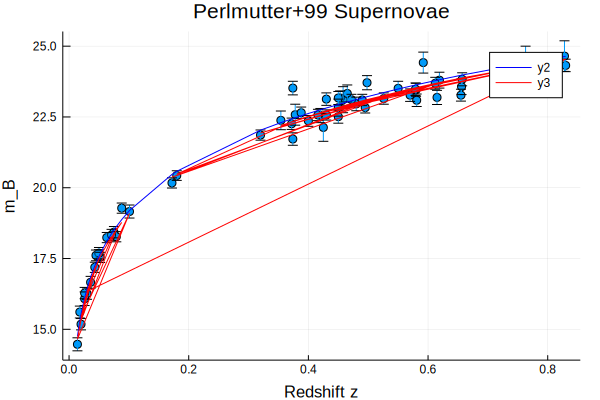

In [14]:
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")
plot!(z_new,DM .+ 20.1,color=:blue)
plot!(z,DM2 .+ 20,color=:red)

The above figure shows the importance of reordereing the data. The unordered plot, shown in blue, has lines that connect the different points of the function according to their position in the array. The ordered plot, in red, connects the points of the function in order of their z-values, giving a smooth curve.

Now we can use a Gibbs sampling MCMC to find the line of best fit. The run_gibbs_mcmc function was written by Dr. Lang and was copied from the course notes.

In [15]:
function run_gibbs_mcmc(logprob_function, initial, jumpsizes, nsteps)
    nparams = length(initial)
    chain = zeros((nsteps, nparams))
    logprobs = zeros(nsteps)
    params = initial
    logprob = logprob_function(params)
    accepts = zeros(nparams)
    tries = zeros(nparams)
    for i in 1:nsteps
        # Choose which parameter to adjust this time
        j = rand(1:nparams)
        # Jump just that parameter.
        params_new = copy(params)
        params_new[j] += randn() * jumpsizes[j]
        logprob_new = logprob_function(params_new)
        if (exp(logprob_new - logprob) >= rand(Float64))
            logprob = logprob_new
            params = params_new
            accepts[j] += 1
        end
        tries[j] += 1
        chain[i,:] .= params
        logprobs[i] = logprob
    end
    return chain, logprobs, accepts ./ tries
end;

### Fitting to the function: EMCEE sampling

We can also use EMCEE sampling to find the best fit. The ensemble_sampler code code was written by Dr. Lang and was copied from the course notes.

In [16]:
function ensemble_sampler(logprob_func, initial, nsteps)
    # A translation of the "emcee" ensemble sampler by Dan Foreman-Mackey,
    # http://arxiv.org/abs/1202.3665.  This is "Algorithm 3" in that paper.
    #
    # *logprob_func* is a log-posterior-probability function of the parameters.
    # *initial* must be an array with shape (Nwalkers, Nparams)
    # *nsteps* is the desired number of MCMC steps to take
    #
    nwalkers, nparams = size(initial)
    if (nwalkers % 2 != 0)
        println("NWalkers must be even")
        return
    end
    chain = zeros((nsteps, nwalkers, nparams))
    logprobs = zeros(nwalkers)
    nhalf = Int(nwalkers/2)
    # Start at initial parameter values
    params = initial
    for j in 1:nwalkers
        logprobs[j] = logprob_func(params[j,:])
    end
    # "Stretch move" parameter
    alpha = 2.
    # Tried moves
    tries = 0
    # Accepted moves
    accepts = 0
    for i in 1:nsteps
        # At each step, we first update one half of the ensemble (holding the other half fixed)
        # and then updated the second half (holding the first half, with its updated values, fixed)
        for half in 0:1
            for j in 1:nhalf
                # We're going to update the walker at index "me":
                me = half*nhalf + j
                # Draw a walker from the other half of the walkers
                other = (1-half)*nhalf + rand(1:nhalf)
                # Draw the "stretch move" distance
                z = ((alpha - 1.) * rand(Float64) + 1)^2 / alpha
                # Compute the parameter value -- it is along the line connecting "me" and "other"
                params_new = params[other,:] .+ z .* (params[me,:] - params[other,:])
                # Compute the log-prob at the new sample location
                logprob_new = logprob_func(params_new)
                # There is an extra term that weights the proposal distribution -- required to maintain
                # detailed balance.
                logproposal = (nparams-1) * log(z)
                tries += 1
                # Keep this new sample?
                if exp(logproposal+logprob_new - logprobs[me]) >= rand(Float64)
                    # Keep it!
                    params[me,:] = params_new
                    logprobs[me] = logprob_new
                    accepts += 1
                end
                # Record the chosen parameter values
                chain[i, me, :] .= params[me, :]
            end
        end
    end
    return chain, accepts/tries
end;

## Results and Analysis

First run both the Gibbs and EMCEE sampler with an initial guess.

In [17]:
# Run the Gibbs sampler by guessing some initial parameters
initial = [15, 1, 0.1, mean(m), var(m)]
jumpsizes = [2, 0.2, 0.1, 2., 1.]
nsteps1 = 100000
chain1,logprobs1,acceptance1 = run_gibbs_mcmc(fgbg_simp, initial, jumpsizes, nsteps1);
acceptance1

5-element Array{Float64,1}:
 0.022511129097531363
 0.323519120219945   
 0.4527628337271859  
 0.361243072050673   
 0.632836562344759   

In [18]:
# Let's use the same initial parameters as before for the EMCEE sampler

jumpsizes = ones(length(initial)) * 1e-6
nparams = length(initial)

nwalkers = 20

# Initialize the walkers in a ball around *initial*.
walkers = zeros((nwalkers, nparams))
for i in 1:nwalkers
    walkers[i,:] = initial + randn(nparams) .* jumpsizes
end
# Call the sampler
nsteps2 = 10_000
chain2,acceptance2 = ensemble_sampler(fgbg_simp, walkers, nsteps)
acceptance2

UndefVarError: UndefVarError: nsteps not defined

Now look at the samples that have been taken, the parameter values should begin to steady out after a certain number of steps called the burnin.

In [19]:
# Examining the Gibbs sampler
names = ["M", "Omat", "pbad", "Y", "V"]
plots = []
for (i,n) in enumerate(names)
    p = plot(chain1[:,i], xlabel="MCMC step", ylabel=n, label="", tickfontsize=:5)
    push!(plots, p)
end
plot(plots...)

While the parameter "V" begins to vary later on, the parameters we are trying ro fit, "M" and "Omat", steady out after 25000 or so steps.

In [20]:
#Examining the EMCEE sampler
p1 = plot(chain2[:,:,1], legend=false, ylabel="M", xlabel="MCMC step", tickfontsize=:7)
p2 = plot(chain2[:,:,2], legend=false, ylabel="Omat", xlabel="MCMC step", tickfontsize=:7)
p3 = plot(chain2[:,:,3], legend=false, ylabel="Pbad", xlabel="MCMC step", tickfontsize=:7)
p4 = plot(chain2[:,:,4], legend=false, ylabel="Y", xlabel="MCMC step", tickfontsize=:7)
p5 = plot(chain2[:,:,5], legend=false, ylabel="V", xlabel="MCMC step", tickfontsize=:7)
plot(p1,p2,p3,p4,p5)

UndefVarError: UndefVarError: chain2 not defined

Looking at the plot M versus the MCMC step, it is clear that something is going wrong with some  of the walkers. Some of the walkers are settling at M < 15, when it is clear from the plot of the date that M must be around 20. Indeed, calculating the log probabilities for when M < 15 gives values less than -100, whereas calculating the log probabilities when M is approximately 20 gives values that are around -15. It is unclear what exactly is going wrong with ensemble_sampler, but we can eliminate the walkers that go astray using the following code:

In [21]:
# count the number of "bad" walkers
count = 0
goodWalk = zeros(nwalkers)
for i in 1:nwalkers
    if fgbg_SNLLL(z, m, merr, chain[end,i,1], chain[end,i,2], chain[end,i,3], chain[end,i,4], chain[end,i,5]) < -50
        count = count + 1
        goodWalk[i] = 0
    else
        goodWalk[i] = 1
    end
end

# create a new array with only the "good" walkers
chain_new = zeros(nsteps,nwalkers-count,nparams)
j = 0
for i in 1:nwalkers
    if goodWalk[i] == 1
        j = j+1
        chain_new[:,j,:] = chain[:,i,:]
    end
end

UndefVarError: UndefVarError: chain not defined

In [22]:
#Plot the improved result of the EMCEE sampler
p1 = plot(chain_new[:,:,1], legend=false, ylabel="M", xlabel="MCMC step", tickfontsize=:7)
p2 = plot(chain_new[:,:,2], legend=false, ylabel="Omat", xlabel="MCMC step", tickfontsize=:7)
p3 = plot(chain_new[:,:,3], legend=false, ylabel="Pbad", xlabel="MCMC step", tickfontsize=:7)
p4 = plot(chain_new[:,:,4], legend=false, ylabel="Y", xlabel="MCMC step", tickfontsize=:7
p5 = plot(chain_new[:,:,5], legend=false, ylabel="V", xlabel="MCMC step", tickfontsize=:7)
plot(p1,p2,p3,p4,p5)

UndefVarError: UndefVarError: chain_new not defined

The plots look a bit better now, but the variance of the background "V" is still very eratic.

However, we are mostly concerned with "M" and "Omat", so now we can take a look at the histograms of M versus Omat

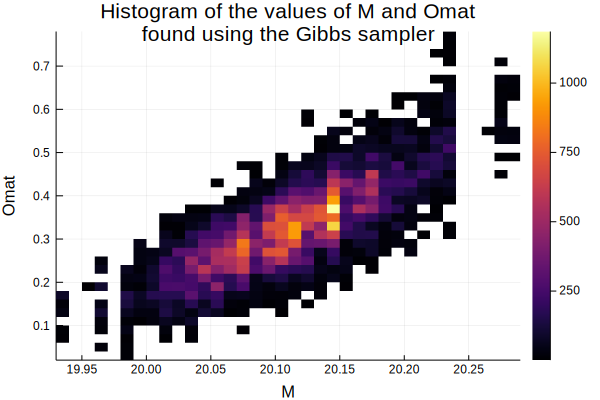

In [23]:
burnin1 = 25000

# Remove the burnin from the chain and plot the histogram for the Gibbs sampler

MCMC_M = chain1[burnin1:end,1]
MCMC_Omat = chain1[burnin1:end,2]
histogram2d(MCMC_M, MCMC_Omat,xlabel=:"M",ylabel=:"Omat",
    title=:"Histogram of the values of M and Omat \n found using the Gibbs sampler")

In [24]:
burnin2 = 5_000

# Remove the burnin from the chain, collapse the number of walkers to one (method copied from class notes)
# and plot the histogram for the EMCEE sampler

flat = chain_new[burnin2:end,:,:]
nb,nw,np = size(flat)
flat = reshape(flat, (nb*nw,np));

histogram2d(flat[:,1], flat[:,2],xlabel=:"M",ylabel=:"Omat",
    title=:"Histogram of the values of M and Omat \n found using the EMCEE sampler")

UndefVarError: UndefVarError: chain_new not defined

The histograms show the frequency with which each value of "Omat" and "M" were sampled. It is clear from the histograms that the samples of M and Omat have nice gaussian distributions using both the Gibbs and the EMCEE sampler.

Now we can find the best fit for the functions by finding the position in each chain of samples that gives the highest value of fgbg_SNLLL, and we can plot those best fits:

In [25]:
# Find the parameters that maximize the log-likelihood for both the Gibbs and EMCEE samplers

nsteps1 = length(chain1)

prob = -100
position1 = 0
for n in burnin1:nsteps
    # calculate the log-likelihood at step n
    prob_new = fgbg_SNLLL(z, m, merr, chain1[n,1], chain1[n,2], chain1[n,3], chain1[n,4], chain1[n,5])
    # If the new likelihood is greater than the old one, remember likelihood and the position where it occured
    if prob_new > prob
        prob = prob_new
        position1 = n
    end
end

nsteps2,npar2 = size(flat)

prob = -100
position2 = 0
for n in 1:nsteps
    # calculate the log-likelihood at step n
    prob_new = fgbg_SNLLL(z, m, merr, flat[n,1], flat[n,2], flat[n,3], flat[n,4], flat[n,5])
    if prob_new > prob
        # If the new likelihood is greater than the old one, remember likelihood and the position where it occured
        prob = prob_new
        position2 = n
    end
end

UndefVarError: UndefVarError: nsteps not defined

In [26]:
# Plot the data points
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",legend=:bottomright,
title="Perlmutter+99 Supernovae")

# Find the best M and Omat from the Gibbs Sampler
M_bestG,Omat_bestG = chain1[position1,1], chain1[position1,2]

# Calculate the function and plot it
universe1 = LCDM(Omat_bestG,1-Omat_bestG, 60.)
DM1 = map(z_new->distance_modulus(universe2,z_new),z_new)

plot!(z_new,DM1 .+ M_meanG,color=:green, label="Best Fit with Gibbs Sampler")

# Find the best M and Omat from the Gibbs Sampler
M_bestE,Omat_bestE = flat[position2,1], flat[position2,2]

# Calculate the function and plot it
universe2 = LCDM(Omat_bestE,1-Omat_bestE, 60.)
DM2 = map(z_new->distance_modulus(universe,z_new),z_new)

plot!(z_new,DM2 .+ M_bestE, color=:red, label="Best Fit with EMCEE Sampler")

BoundsError: BoundsError: attempt to access 100000×5 Array{Float64,2} at index [0, 1]

So the two best-fit curves are very similar, as predicted.

## Conclusion

 The values of Omega_matter and their variances (which are the variances of the sampled Omat after the burnin) are given below, as are the "best" values of pbad.

In [27]:
print("\n \n The value of Omega_matter using the Gibb's sampler is: ",chain1[position1,2], " plus or minus ",
    var(chain1[burnin1:end,2]),
    "\n The value of Omega_matter using the EMCEE sampler is: ",flat[position2,2]," plus or minus ",
    var(flat[:,2]),
    "\n \n The value of pbad using the Gibb's sampler is: ",chain1[position1,3],
    "\n The value of pbad using the EMCEE sampler is: ",flat[position2,3])

BoundsError: BoundsError: attempt to access 100000×5 Array{Float64,2} at index [0, 2]

So the calculated values of Omega_matter are approximately the same to within statistical error, although they are bigger than the value obtained by Perlmutter et al, 0.28 plus or minus 1.

The values of pbad tell us the percentage of points that safely disregarded, just multiply pbad by 100%. Appendix A contains two functions to find which points are outliers, but neither function has been checked for typos or properly commented due to time constraints, so they were not included in the body of the project.

## Appendix A:

Contains functions ptTest and worst, which can be used to determine which data points are outliers.

In [28]:
# This function outputs the values of the foreground and background distributions at a each point

function ptTest(x, y, sigma, M, Omat, pbad, Y, V)
    # If the "pbad" parameter goes outside the range 0 to 1, the prior is zero, so bail out.
    if (pbad < 0) || (pbad > 1)
        return -Inf
    end
    # If the "V" parameter goes negative, the prior is zero; bail out.
    if (V < 0 || V > 100)
        return -Inf
    end
    if (Omat < 0 || Omat > 1)
        return -Inf
    end
    if M < 0
        return -Inf
    end
    
    universe = LCDM(Omat ,1.0-Omat, 60.)
    DM = map(x->distance_modulus(universe,x),x)

    predM = M .+ DM
    
    # Note -- don't work in log space here, and do include the 1/(sqrt(2*pi)*sigma) term.
    p_fg = @. 1. / (sqrt(2. *pi) * sigma) * exp(-0.5 * (predM - y)^2/(sigma^2))
    bg_var = @. sigma^2 + V
    p_bg = @. 1. / sqrt(2. *pi*bg_var) * exp(-0.5 * (y - Y)^2/bg_var)
    # Here, we weight the foreground probability by 1-pbad and the background by pbad,
    # and then take the log.
    p_good = (1. .- pbad).*p_fg
    p_bad = pbad.*p_bg
    return p_good,p_bad
end;

In [29]:
good,bad = ptTest(z, m, merr, chain1[position1,1], chain1[position1,2], chain1[position1,3], chain1[position1,4],chain1[position1,5])

BoundsError: BoundsError: attempt to access 100000×5 Array{Float64,2} at index [0, 1]

In [30]:
histogram(bad, xlabel="M",bins=:10, label="")

UndefVarError: UndefVarError: bad not defined

In [31]:
#this function uses the result of ptTest and the value of pBad to determine the outliers. It is very similar to 
#the reorder function

function worst(b,percent)
    n = length(b)
    num_bad = Int(ceil(percent*n))
    ai_temp = 0
    bi_temp = 0
    
    a_new = zeros(n)
    b_new = zeros(n)
    
    for p in 1:n
        a_new[p] = p
        b_new[p] = b[p]
    end
    
    for i in 1:n
        for j in 1:n
            if b_new[i] < b_new[j]
                ai_temp = a_new[i]
                bi_temp = b_new[i]
                a_new[i] = a_new[j]
                b_new[i] = b_new[j]
                a_new[j] = ai_temp
                b_new[j] = bi_temp
            end
        end
    end
    
    bd = zeros(num_bad)
    for i in 1:num_bad
        bd[i] =  a_new[n+1-i]
    end
    
    return bd
    
end

worst (generic function with 1 method)

## Works Cited

S. Perlmutter et al "Measurements of Omega and Lambda from high-redshift supernovae" https://arxiv.org/abs/astro-ph/9812133

D. Lang "data-analysis-module" https://github.com/eschnett/2018-computational-physics-course/tree/master/data-analysis-module
